# QUIZ 5 - Object Recognition: BoF vs ConvNetsTarefa

### Grupo: Luiz Gontijo, Marcos Vinicius, Matheus Pimenta

O objetivo deste Quiz é implementar e comparar duas maneiras de reconhecimento de objetos. 

In [70]:
import numpy as np
import pickle
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.misc as smp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Bag of Features

Os passos necessários para realizar o bag of features são:
1. Dataset aleatório
2. SIFT pra cada uma das imagens
3. Comparar descritores do SIFT e separar em grupos (clusters)
4. Criar um representante para cada grupo (média do grupo)
5. Classificar todas as imagens (data e label)
    data = [[1,2,3],[1,3,5],...] | label = [0,1,2,...]
6. Passar pros modelos de aprendizado

In [71]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [72]:
batch1 = unpickle("./cifar-10-python/cifar-10-batches-py/data_batch_1")
# for key in batch1:
#     print(key, '->', batch1[key])



## Carregando o dataset
Uma pequena demo do dataset a ser usado nesse notebook. O dataset foi dado pelo professor. São vários batches de 10 000 imagens cada. Associada à imagem está o label no qual ela pertence.

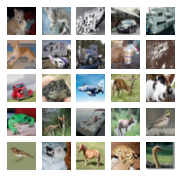

In [73]:
X = batch1[b"data"] 
Y = batch1[b'labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])


## Função para gerar os descritores de uma imagem
Essa função é necessária tanto no paso de montagem do modelo quanto no teste do próprio. Precisamos de um modo de extrair as features das imagens, e foi escolhido utilizar o SIFT do OpenCV.

In [74]:
def get_SIFT_desc(img):
    sift = cv.SIFT_create()
    k, d = sift.detectAndCompute(img, None)
    return k, d

Uma função auxiliar que recebe um dataset e pega uma imagem aleatória dele, assim como sua label.

In [75]:

def get_random_img(dataset):
    X = dataset[b"data"]
    Y = dataset[b"labels"]
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    i = np.random.choice(range(len(X)))
    return X[i:i+1][0], Y[i]

## Criação dos clusters
A função get_descriptors_n_imgs utiliza a função do SIFT para extrair os descritores das imagens e os agrupa. Esses descritores serão utilizados na função create_clusters para criar grupos a partir dos descritores e retornar um representante de cada um deles (centers). Para isso, foi utilizado o KMeans do Opencv.

In [76]:
def get_descriptors_n_imgs(dataset, n):
    descs = []
    for i in range(n):
        img, _ = get_random_img(dataset)
        _, desc_array = get_SIFT_desc(img)

        if desc_array is not None:
            for elem in desc_array:
                descs.append(elem)

    descs = np.array(descs)
    return descs


def create_clusters(descs, k, attempts):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,_,center = cv.kmeans(descs,k,None,criteria,attempts,cv.KMEANS_RANDOM_CENTERS)
    return center

## Geração dos histogramas
Essa função recebe uma imagem e utiliza o dicionário criado no passo anterior para retornar o histograma dos descritores dessa imagem em relação aos descritores presentes no dicionário. Para isso, ela calcula a distância de cada um dos descritores da imagem em relação aos elementos do discionário. 

In [77]:
def generate_hist(img, vocab):
    k, d = get_SIFT_desc(img)
    # n1 = d[0]
    # n2 = vocab[0]
    # diff = sum( np.sqrt ([x**2 for x in n1] - [x**2 for x in n2]))
    histograma = []
    for word in vocab:
        aux = 0
        if d is not None:
            for elem in d:
                foo = [x**2 for x in elem]
                bar = [x**2 for x in word]
                # print(np.sqrt ( [np.abs(x1 - x2) for (x1, x2) in zip(foo, bar)]))
                luiz = sum ( np.sqrt ( [np.abs(x1 - x2) for (x1, x2) in zip(foo, bar)]))
                if( luiz <= 4200.0 ): #32.8125
                    aux = aux + 1
        
        histograma.append(aux)

                
    return histograma

Função auxiliar que extrai um set de treino a partir de um dataset passado como parâmetro.

In [78]:
def get_train_set(dataset, vocab, n_samples):
    X = []
    Y = []
    for i in range(n_samples):
        img, y = get_random_img(dataset)
        Y.append(y)
        # d = get_SIFT_desc(img)
        X.append(generate_hist(img,vocab))

    return X, Y

## Random Forest
Utiliza o algoritmo de random forest do sklearn com o dicionário criado nos passos anteriores. A função recebe alguns parâmetros que definem a quantidade de imagens, de samples, de clusters e de testes que serão realizados. Ela retorna um array contendo os labels obtidos assim como um array com os labels esperados.

In [79]:
def runRandomForest(dataset, n_images, n_samples, k_clusters, k_attempts, n_tests):
    clf = RandomForestClassifier()
    
    descs = get_descriptors_n_imgs(dataset, n_images)
    centers = create_clusters(descs, k_clusters, k_attempts)
    X,Y = get_train_set(dataset, centers, n_samples)

    clf.fit(X, Y)

    data = dataset[b"data"]
    labels = dataset[b"labels"]
    data = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

    images_hist = []
    expected = []

    for i in range(n_tests):
        img = data[i:i+1][0]
        h = generate_hist(img, centers)
        images_hist.append(h)
        label = labels[i]
        expected.append(label)
    
    predicted = clf.predict(images_hist)
    return predicted, expected


## Testando o Random Forest
Nesse passo testamos a implementação do random forest com diferentes tamanhos de dicionários (quantidade de clusters - k). Foi escolhido um k variando de 10 em 10, indo de 10 até 100. Esse é um intervalo de k pequeno, mas foi decidido dessa forma pois valores mais altos demorariam muito para rodar. Portanto, a precisão esperada não é muito alta, mas deve ser observado que ela aumenta a media que k aumenta. 

In [81]:
N_IMAGES = 1000
N_SAMPLES = 200
K_ATTEMPTS = 5
N_TESTS = 100


predicted_arr = []
expected_arr = []
score_arr = []
con_matrix_arr = []

for i in range(10, 110, 10):
    print("running for k =", i)
    predicted, expected = runRandomForest(batch1, N_IMAGES, N_SAMPLES, i, K_ATTEMPTS, N_TESTS)
    score = accuracy_score(expected, predicted)
    con_mat = confusion_matrix(expected, predicted)
    
    predicted_arr.append(predicted)
    expected_arr.append(expected)
    score_arr.append(score)
    con_matrix_arr.append(con_mat)



running for k = 10
running for k = 20
running for k = 30
running for k = 40
running for k = 50
running for k = 60
running for k = 70
running for k = 80
running for k = 90
running for k = 100


In [82]:
print(score_arr)

[0.17, 0.17, 0.2, 0.17, 0.23, 0.19, 0.23, 0.17, 0.21, 0.19]


In [83]:
def runNeuralNetwork(dataset, n_images, n_samples, k_clusters, k_attempts, n_tests):
    neural_net = MLPClassifier()
    
    descs = get_descriptors_n_imgs(dataset, n_images)
    centers = create_clusters(descs, k_clusters, k_attempts)
    X,Y = get_train_set(dataset, centers, n_samples)

    neural_net.fit(X, Y)

    data = dataset[b"data"]
    labels = dataset[b"labels"]
    data = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

    images_hist = []
    expected = []

    for i in range(n_tests):
        img = data[i:i+1][0]
        h = generate_hist(img, centers)
        images_hist.append(h)
        label = labels[i]
        expected.append(label)
    
    predicted = neural_net.predict(images_hist)
    return predicted, expected

## Testando o Neural Network
Nesse passo testamos a implementação do Neural Network com os mesmos tamanhos de dicionários testados para o Random Forest.

In [84]:
neural_predicted_arr = []
neural_expected_arr = []
neural_score_arr = []
neuralcon_matrix_arr = []

for i in range(10, 110, 10):
    print("running for k =", i)
    predicted, expected = runNeuralNetwork(batch1, N_IMAGES, N_SAMPLES, i, K_ATTEMPTS, N_TESTS)
    score = accuracy_score(expected, predicted)
    con_mat = confusion_matrix(expected, predicted)
    
    neural_predicted_arr.append(predicted)
    neural_expected_arr.append(expected)
    neural_score_arr.append(score)
    neuralcon_matrix_arr.append(con_mat)

running for k = 10


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 20


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 30


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 40


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 50


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 60


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 70


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 80


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 90


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


running for k = 100


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
print(neural_score_arr)

[0.16, 0.11, 0.15, 0.17, 0.18, 0.21, 0.17, 0.15, 0.11, 0.14]


In [ ]:
# TESTES
# img = get_random_img(batch1)
# k, d = get_SIFT_desc(img)
# copy = img.copy()
# copy = cv.drawKeypoints(img,k,copy,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow(copy)
# plt.show()
N_IMAGES = 1000
N_SAMPLES = 200
K_CLUSTERS = 100
K_ATTEMPTS = 15
descs = get_descriptors_n_imgs(batch1, N_IMAGES)
centers = create_clusters(descs, K_CLUSTERS, K_ATTEMPTS)
# print(centers)
X,Y = get_train_set(batch1, centers, N_SAMPLES)
print(len(X))
print(len(Y))

clf = RandomForestClassifier()
clf.fit(X, Y)


200
200


RandomForestClassifier()

In [ ]:
img, y = get_random_img(batch1)
h = generate_hist(img, centers)
h = np.reshape(h,(1, -1))
print(clf.predict(h))
print(y)

[5]
4


In [ ]:
neural_net = MLPClassifier()
neural_net(X, Y)

In [ ]:
img, y = get_random_img(batch1)
h = generate_hist(img, centers)
h = np.reshape(h,(1, -1))
print(neural_net.predict(h))
print(y)

In [ ]:
# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)